In [84]:
import os
import glob
import pandas as pd
import numpy as np
import seaborn as sns

main_directory = os.path.normpath(os.getcwd() + os.sep + os.pardir)
data_directory = os.path.join(main_directory, 'TeamStats')
file_names = [f for f in os.listdir(data_directory) if os.path.isfile(os.path.join(data_directory, f))]



In [85]:
#seperate excel files

off_files = [file for file in file_names if 'Off.csv' in file]
def_files = [file for file in file_names if 'Def.csv' in file]
adv_files = [file for file in file_names if 'Adv.csv' in file]
playoff_files = [file for file in file_names if 'Playoffs.csv' in file]

off_files = sorted(off_files)
def_files = sorted(def_files)
adv_files = sorted(adv_files)
playoff_files = sorted(playoff_files)


In [87]:
# Dictionary to store DataFrames
team_stats_dfs = {}
normalized_team_dfs = {}

for i in range(25):

    # Cleanup defensive stats
    def_stats = pd.read_csv(def_files[i])
    def_stats = def_stats.drop(columns=['Rk','Team▲','G','MP'])
    def_stats = def_stats.add_prefix('Opp ')
    #def_stats.drop(def_stats.tail(1).index, inplace=True)
    
    # Cleanup advanced stats
    adv_stats = pd.read_csv(adv_files[i], header=1)
    adv_stats = adv_stats.drop(columns=['Rk','Team▲','Unnamed: 17','Unnamed: 22','Unnamed: 27','Arena','Attend.','Attend./G'])
    adv_stats = adv_stats.rename(columns={'eFG%.1': 'Opp eFG%', 'TOV%.1': 'Opp TOV%', 'FT/FGA.1': 'Opp FT/FGA'})
    #adv_stats = adv_stats.rename(columns={'Attend./G': 'Attend/G'})
    #adv_stats.drop(adv_stats.tail(1).index, inplace=True)
    
    # Cleanup main team stats (offensive)
    off_stats = pd.read_csv(off_files[i])
    off_stats = off_stats.drop(columns=['Rk','G','MP'])
    #off_stats.drop(off_stats.tail(1).index, inplace=True)
    off_stats['Team▲'] = off_stats['Team▲'].str.replace('*', '')
    off_stats = off_stats.rename(columns={'Team▲': 'Team'}) 
    off_stats['Team'] = off_stats['Team'].replace('Seattle SuperSonics', 'Seattle Supersonics')
    #in 2014 Charlotte switched mascots midseason
    if i == 14:
        off_stats['Team'] = off_stats['Team'].replace('Charlotte Bobcats', 'Charlotte Hornets')
    
    # Make one big df of every stat
    team_stats = pd.concat([off_stats, def_stats, adv_stats], axis=1)

    #Add the year to the name
    year = 2000 + i
    team_stats['Team'] = team_stats['Team'] + ' ' + str(year)

    #replace win and loss columns with winning percentage (2020 and 2021 had shortened seasons)
    winrate = team_stats['W']/(team_stats['W'] + team_stats['L']) 
    pwinrate = team_stats['PW']/(team_stats['PW'] + team_stats['PL'])
    team_stats.insert(44, 'W%', winrate)
    team_stats.insert(47, 'PW%', pwinrate)
    team_stats = team_stats.drop(columns=['W','L','PW','PL'])
    
    if i == 24:
        team_stats2024 = team_stats.copy()

    else:
    
        # Read in playoff stats
        playoff = pd.read_csv(playoff_files[i], header=1)
        playoff = playoff[['Team', 'W', 'L']]
        playoff.drop(playoff.tail(1).index, inplace=True)
        year = 2000 + i
        playoff['Team'] = playoff['Team'] + ' ' + str(year)

        # New DataFrame for just team names of all the teams
        all_team_names = team_stats['Team']
        all_team_names_df = pd.DataFrame(all_team_names, columns=['Team'])

        # Add the teams that missed the playoffs
        all_teams = pd.concat([playoff, all_team_names_df]).drop_duplicates(subset=['Team'])

        # Replace NaN with 0
        all_teams = all_teams.fillna(0)

        """
        # Sort by wins and losses to categorize
        all_teams.sort_values(by=['W', 'L'], ascending=[True, True], inplace=True)
   
        # Create the groups; lower number means you got further in the bracket
        x = len(all_teams) - 16
        group_num = [6] * x + [5, 5, 5, 5, 5, 5, 5, 5, 4, 4, 4, 4, 3, 3, 2, 1]
    
        # Add the "Playoff Success" column to the DataFrame
        all_teams = all_teams.assign(Playoff_Success=group_num)
        
        # Sort by team alphabetically
        all_teams.sort_values(by='Team', inplace=True)
        
        # Reset index
        all_teams.reset_index(drop=True, inplace=True)

    
        # Put the new vector in the main df
        playoff_success = all_teams.drop(columns=['Team', 'W', 'L'])
        """
        # Sort by team alphabetically
        all_teams.sort_values(by='Team', inplace=True)
        # Reset index
        all_teams.reset_index(drop=True, inplace=True)
        
        playoff_wins = all_teams.drop(columns=['Team','L'])
        
        team_stats = pd.concat([team_stats, playoff_wins], axis=1)

        ##################################################
        normalized_team = team_stats.copy()

        team_col = normalized_team['Team'].copy()
        normalized_team = normalized_team.drop(normalized_team.columns[0], axis=1)

        avg_W_perc = normalized_team['W%'].mean()
        avg_W = normalized_team['W'].mean()

        normalized_team.at[29,'W%'] = avg_W_perc
        normalized_team.at[29,'NRtg'] = 1
        normalized_team.at[29,'MOV'] = 1
        normalized_team.at[29,'SOS'] = 1
        normalized_team.at[29,'SRS'] = 1
        normalized_team.at[29,'W'] = avg_W

        divisor_row = normalized_team.iloc[29]
        normalized_team = normalized_team.div(divisor_row, axis=1)
        normalized_team.insert(0, 'Team', team_column)

        normalized_team.drop(normalized_team.tail(1).index, inplace=True)

        normalized_team_dfs[i] = normalized_team.copy()
        
        ##################################################

        team_stats.drop(team_stats.tail(1).index, inplace=True)
        
        team_stats_dfs[i] = team_stats.copy()
        




Index(['FG', 'FGA', 'FG%', '3P', '3PA', '3P%', '2P', '2PA', '2P%', 'FT', 'FTA',
       'FT%', 'ORB', 'DRB', 'TRB', 'AST', 'STL', 'BLK', 'TOV', 'PF', 'PTS',
       'Opp FG', 'Opp FGA', 'Opp FG%', 'Opp 3P', 'Opp 3PA', 'Opp 3P%',
       'Opp 2P', 'Opp 2PA', 'Opp 2P%', 'Opp FT', 'Opp FTA', 'Opp FT%',
       'Opp ORB', 'Opp DRB', 'Opp TRB', 'Opp AST', 'Opp STL', 'Opp BLK',
       'Opp TOV', 'Opp PF', 'Opp PTS', 'Age', 'W%', 'PW%', 'MOV', 'SOS', 'SRS',
       'ORtg', 'DRtg', 'NRtg', 'Pace', 'FTr', '3PAr', 'TS%', 'eFG%', 'TOV%',
       'ORB%', 'FT/FGA', 'Opp eFG%', 'Opp TOV%', 'DRB%', 'Opp FT/FGA'],
      dtype='object')


/opt/anaconda3/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/opt/anaconda3/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/opt/anaconda3/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/opt/anaconda3/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before opera

,W%,ORtg,DRtg,NRtg,Pace,FTr,3PAr,TS%
Team,,,,,,,,
Atlanta Hawks 2000,0.341463,102.0,107.9,-5.9,91.7,0.292,0.120,0.503
Boston Celtics 2000,0.426829,104.8,105.6,-0.8,94.6,0.316,0.183,0.520
Charlotte Hornets 2000,0.597561,104.3,101.4,2.9,93.9,0.376,0.153,0.530
Chicago Bulls 2000,0.207317,94.2,104.6,-10.4,89.4,0.338,0.167,0.490
Cleveland Cavaliers 2000,0.390244,100.4,104.0,-3.6,95.7,0.327,0.136,0.516
Dallas Mavericks 2000,0.487805,106.6,107.2,-0.6,94.9,0.248,0.188,0.532
Denver Nuggets 2000,0.426829,103.5,105.8,-2.3,94.7,0.306,0.202,0.517
Detroit Pistons 2000,0.512195,107.3,105.8,1.5,95.7,0.378,0.184,0.548
Golden State Warriors 2000,0.231707,99.8,108.4,-8.6,95.4,0.301,0.150,0.484


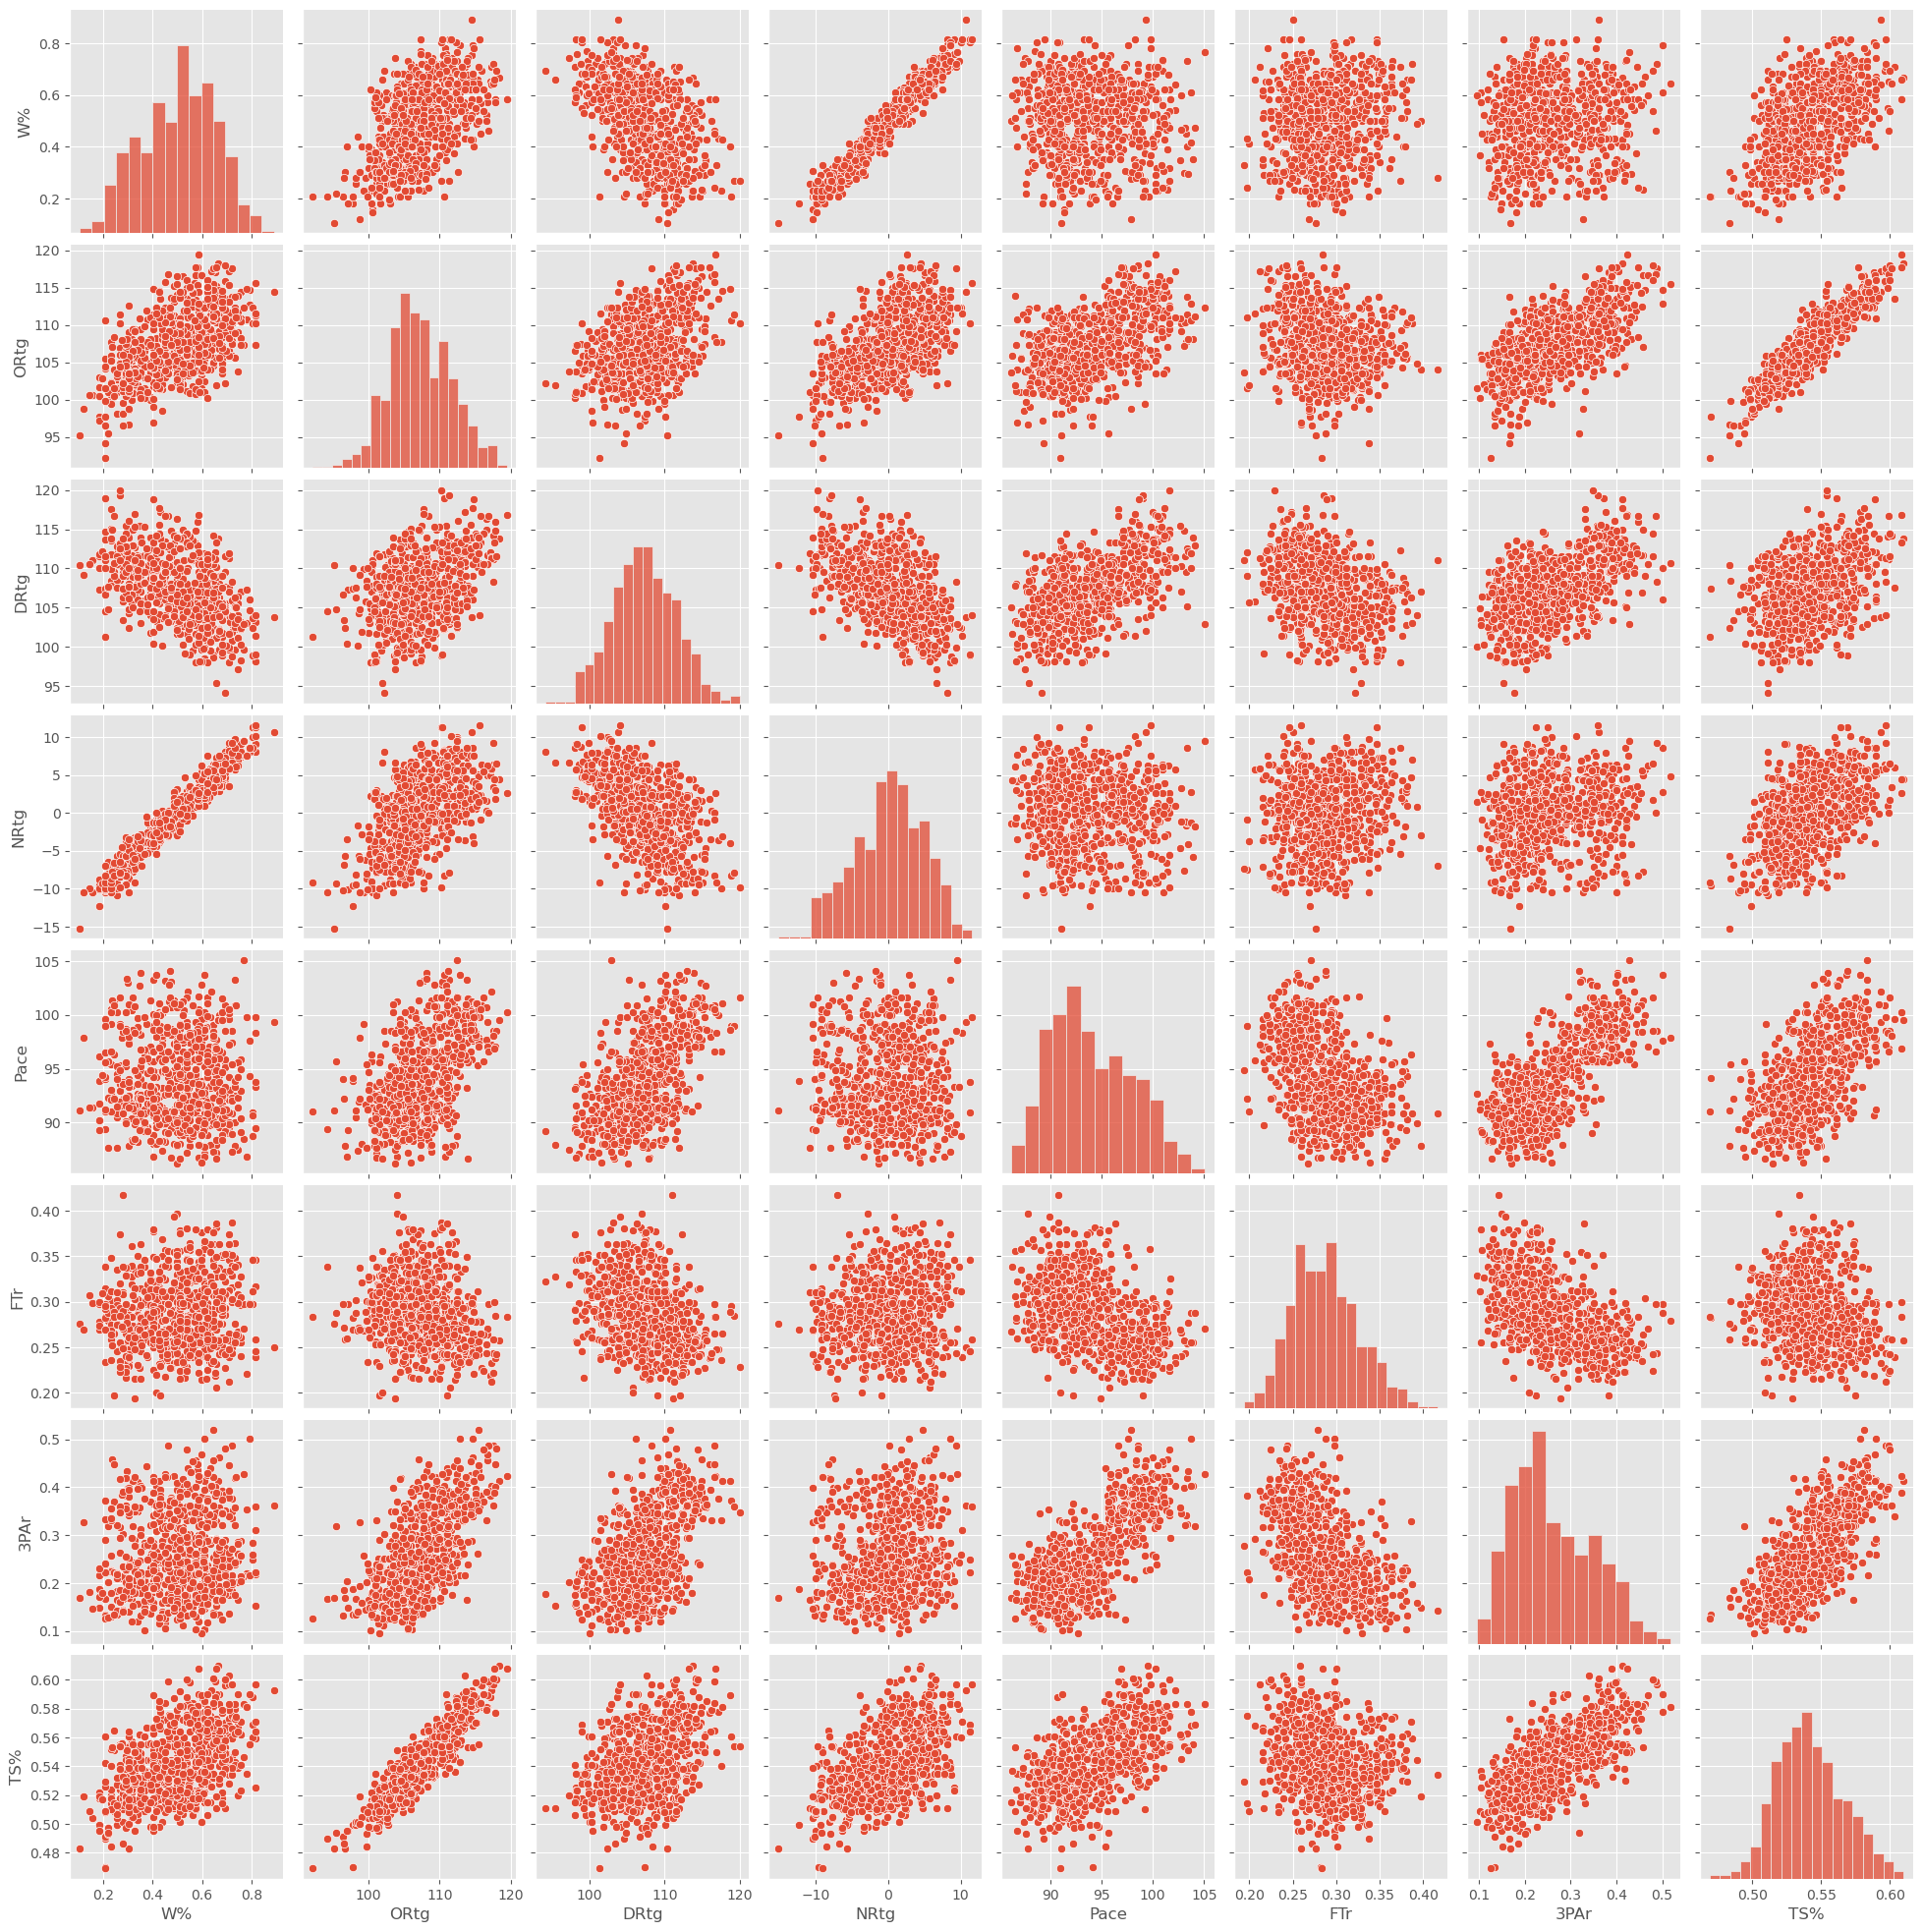

In [94]:
# Combine all DataFrames into one giant DataFrame
all_data = pd.concat(team_stats_dfs.values(), ignore_index=True)
all_data.set_index('Team', inplace=True)

X = all_data
X = X.drop(columns=['W'])
y = all_data['W']
print(X.columns)
pd.set_option('display.max_rows',None)
pd.set_option('display.max_columns', None)

d = all_data[['W%','ORtg', 'DRtg', 'NRtg', 'Pace', 'FTr', '3PAr', 'TS%']]
sns.pairplot(all_data[['W%','ORtg', 'DRtg', 'NRtg', 'Pace', 'FTr', '3PAr', 'TS%']])
d

In [55]:
from sklearn import tree, svm, metrics
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.datasets import load_digits
from sklearn.preprocessing import scale

import matplotlib.pyplot as plt
%matplotlib inline
plt.rcParams['figure.figsize'] = (10, 6)
plt.style.use('ggplot')

In [56]:
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=1, test_size=0.8)

model = svm.SVC(kernel='rbf', C=243)

model.fit(X_train, y_train)   

y_pred = model.predict(X_test)

# Get indices of instances classified as 1
champ_i = np.where(y_pred == 16)[0]

# Select teams classified as 1 from the DataFrame
index = y_test.iloc[champ_i].index
shoulda_won = all.loc[index]
shoulda_won = shoulda_won[['Team','W','W%']]
display(shoulda_won)

print('Confusion Matrix:')
print(metrics.confusion_matrix(y_true = y_test, y_pred = y_pred))

print('Accuracy = ', metrics.accuracy_score(y_true = y_test, y_pred = y_pred))

ValueError: Input X contains NaN.
SVC does not accept missing values encoded as NaN natively. For supervised learning, you might want to consider sklearn.ensemble.HistGradientBoostingClassifier and Regressor which accept missing values encoded as NaNs natively. Alternatively, it is possible to preprocess the data, for instance by using an imputer transformer in a pipeline or drop samples with missing values. See https://scikit-learn.org/stable/modules/impute.html You can find a list of all estimators that handle NaN values at the following page: https://scikit-learn.org/stable/modules/impute.html#estimators-that-handle-nan-values

In [54]:
C_values = np.linspace(1, 400, 100)
accuracies = {}
for C in C_values:
    modelC = svm.SVC(kernel='rbf', C=C)
    
    scores = cross_val_score(modelC, X, y, cv=5)
    
    mean_accuracy = np.mean(scores)
    
    accuracies[C] = mean_accuracy

best_C = max(accuracies, key=accuracies.get)
best_accuracy = accuracies[best_C]

print("Best C: " , best_C)
print("Accuracy = ",best_accuracy)

/opt/anaconda3/lib/python3.11/site-packages/sklearn/model_selection/_split.py:700: UserWarning: The least populated class in y has only 3 members, which is less than n_splits=5.
  warnings.warn(
/opt/anaconda3/lib/python3.11/site-packages/sklearn/model_selection/_split.py:700: UserWarning: The least populated class in y has only 3 members, which is less than n_splits=5.
  warnings.warn(
/opt/anaconda3/lib/python3.11/site-packages/sklearn/model_selection/_split.py:700: UserWarning: The least populated class in y has only 3 members, which is less than n_splits=5.
  warnings.warn(
/opt/anaconda3/lib/python3.11/site-packages/sklearn/model_selection/_split.py:700: UserWarning: The least populated class in y has only 3 members, which is less than n_splits=5.
  warnings.warn(
/opt/anaconda3/lib/python3.11/site-packages/sklearn/model_selection/_split.py:700: UserWarning: The least populated class in y has only 3 members, which is less than n_splits=5.
  warnings.warn(
/opt/anaconda3/lib/python

Best C:  142.06060606060606
Accuracy =  0.5510489510489511


In [64]:

X_data = team_stats2024.drop(columns=['Team'])

model1 = svm.SVC(kernel='rbf', C=200)

model1.fit(X, y)   

playoff_wins = model1.predict(X_data)
place = ['Champion','Finals','Conference Finals','2nd Round','1st round','Missed Playoffs']

NBA_2024 = pd.DataFrame(team_stats2024[['Team','W%']])
NBA_2024.insert(1, 'Playoff Wins', playoff_wins)
NBA_2024.sort_values(by=['Playoff Wins','W%'], ascending=[False, False],inplace=True)
NBA_2024.reset_index(drop=True, inplace=True)
display(NBA_2024)

,Team,Playoff Wins,W%
0,Boston Celtics 2024,16.0,0.791667
1,Minnesota Timberwolves 2024,16.0,0.694444
2,Oklahoma City Thunder 2024,7.0,0.694444
3,New Orleans Pelicans 2024,7.0,0.611111
4,New York Knicks 2024,2.0,0.611111
5,Denver Nuggets 2024,1.0,0.698630
6,Milwaukee Bucks 2024,1.0,0.638889
7,Los Angeles Clippers 2024,0.0,0.625000
8,Cleveland Cavaliers 2024,0.0,0.602740
9,Dallas Mavericks 2024,0.0,0.597222


In [41]:
normalized_team = team_stats_dfs[0].copy

team_column = normalized_team['Team']
normalized_team = normalized_team.drop(normalized_team.columns[0], axis=1)

avg_W_perc = normalized_team['W%'].mean()
avg_W = normalized_team['W'].mean()

normalized_team.at[29,'W%'] = avg_W_perc
normalized_team.at[29,'NRtg'] = 1
normalized_team.at[29,'MOV'] = 1
normalized_team.at[29,'SOS'] = 1
normalized_team.at[29,'SRS'] = 1
normalized_team.at[29,'W'] = avg_W

divisor_row = normalized_team.iloc[29]
normalized_team = normalized_team.div(divisor_row, axis=1)
normalized_team.insert(0, 'Team', team_column)
normalized_team

,Team,FG,FGA,FG%,3P,3PA,3P%,2P,2PA,2P%,FT,FTA,FT%,ORB,DRB,TRB,AST,STL,BLK,TOV,PF,PTS,Opp FG,Opp FGA,Opp FG%,Opp 3P,Opp 3PA,Opp 3P%,Opp 2P,Opp 2PA,Opp 2P%,Opp FT,Opp FTA,Opp FT%,Opp ORB,Opp DRB,Opp TRB,Opp AST,Opp STL,Opp BLK,Opp TOV,Opp PF,Opp PTS,Age,W%,PW%,MOV,SOS,SRS,ORtg,DRtg,NRtg,Pace,FTr,3PAr,TS%,eFG%,TOV%,ORB%,FT/FGA,Opp eFG%,Opp TOV%,DRB%,Opp FT/FGA,W
0,Atlanta Hawks 2000,0.994565,1.010962,0.982183,0.645833,0.722628,0.898017,1.043750,1.068713,0.978632,0.947368,0.956522,0.990667,1.129032,1.026230,1.055944,0.847534,0.772152,1.076923,0.993548,0.901288,0.967179,1.065217,1.048721,1.013363,0.937500,0.905109,1.039660,1.081250,1.077485,1.002137,0.884211,0.865613,1.025333,1.032258,0.990164,1.002331,1.031390,1.012658,0.942308,0.787097,0.957082,1.022564,0.992806,0.682927,0.634146,-5.38,-0.04,-5.41,0.979827,1.036503,-5.9,0.984962,0.948052,0.718563,0.961759,0.962343,0.992958,1.096886,0.939394,1.006276,0.795775,0.998594,0.848485,0.000000
1,Boston Celtics 2000,1.010870,1.021924,0.988864,1.062500,1.124088,0.937677,1.006250,1.001462,1.002137,1.042105,1.047431,0.993333,1.088710,0.967213,1.002331,0.950673,1.227848,0.673077,0.993548,1.163090,1.018462,0.980978,0.936663,1.046771,0.916667,0.883212,1.022663,0.990625,0.945906,1.047009,1.236842,1.237154,1.004000,0.846774,1.013115,0.965035,0.982063,0.987342,1.115385,1.096774,1.008584,1.026667,0.913669,0.853659,0.951220,-0.76,-0.24,-1.00,1.006724,1.014409,-0.8,1.016112,1.025974,1.095808,0.994264,0.991632,0.971831,1.051903,1.021645,1.041841,1.112676,1.037975,1.324675,0.000000
2,Charlotte Hornets 2000,0.972826,0.970767,1.000000,0.854167,0.890511,0.960340,0.990625,0.986842,1.002137,1.194737,1.185771,1.010667,0.870968,1.052459,1.000000,1.107623,1.126582,1.134615,0.948387,0.875536,1.009231,1.010870,1.012180,0.997773,1.041667,0.963504,1.070822,1.006250,1.020468,0.985043,0.863158,0.869565,0.993333,0.951613,1.019672,1.000000,1.040359,0.936709,0.980769,1.019355,1.085837,0.982564,1.032374,1.195122,1.195122,2.67,-0.34,2.33,1.001921,0.974063,2.9,1.008593,1.220779,0.916168,1.013384,0.993724,0.964789,0.889273,1.233766,1.000000,1.028169,1.029536,0.857143,0.386667
3,Chicago Bulls 2000,0.850543,0.918392,0.924276,0.854167,0.919708,0.932011,0.846875,0.918129,0.923077,0.952632,1.007905,0.945333,1.016129,0.927869,0.953380,0.901345,1.000000,0.903846,1.225806,1.000000,0.869744,0.967391,0.950061,1.015590,0.916667,0.934307,0.966006,0.975000,0.953216,1.021368,0.984211,0.996047,0.988000,0.983871,0.967213,0.972028,1.040359,1.316456,1.076923,0.980645,1.030043,0.966154,0.935252,0.414634,0.365854,-9.40,0.17,-9.23,0.904899,1.004803,-10.4,0.960258,1.097403,1.000000,0.936902,0.926778,1.267606,1.034602,1.038961,1.012552,1.021127,0.983122,1.038961,0.000000
4,Cleveland Cavaliers 2000,0.986413,1.000000,0.984410,0.875000,0.817518,1.056657,1.003125,1.036550,0.967949,1.063158,1.063241,1.000000,0.991935,1.000000,0.997669,1.062780,1.101266,0.846154,1.122581,1.163090,0.994872,0.989130,1.000000,0.986637,1.062500,1.094891,0.968839,0.978125,0.982456,0.993590,1.189474,1.150198,1.034667,1.000000,1.032787,1.023310,1.062780,1.012658,1.173077,1.090323,1.077253,1.030769,0.978417,0.780488,0.756098,-3.50,-0.14,-3.64,0.964457,0.999039,-3.6,1.027927,1.061688,0.814371,0.986616,0.979079,1.098592,0.972318,1.060606,0.991632,1.063380,1.001406,1.190476,0.000000
5,Dallas Mavericks 2000,1.059783,1.046285,1.008909,1.312500,1.182482,1.107649,1.018750,1.020468,1.000000,0.905263,0.845850,1.072000,0.919355,0.977049,0.960373,0.991031,0.911392,0.980769,0.883871,0.927039,1.040000,1.067935,1.047503,1.017817,1.083333,1.109489,0.977337,1.065625,1.035088,1.027778,0.952632,0.968379,0.986667,1.233871,1.088525,1.128205,1.040359,0.936709,0.980769,1.038710,0.948498,1.046154,0.946043,0.975610,0.951220,-0.57,0.29,-0.29,1.024015,1.029779,-0.6,1.019334,0.805195,1.125749,1.017208,1.025105,0.887324,0.882353,0.865801,1.020921,1.000000,0.929677,0.909091,0.000000
6,Denver Nuggets 2000,1.013587,1.026797,0.984410,1.187500,1.240876,0.951841,0.984375,0.982456,1.002137,0.984211,1.019763,0.9